In [2]:
import sys
sys.path.append('/kaggle/input/customresnet-dl23')

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
from Custom_ResNet18 import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Mapping from coarse labels to fine labels
coarse_to_fine = {
    0: [4, 30, 55, 72, 95],
    1: [1, 32, 67, 73, 91],
    2: [54, 62, 70, 82, 92],
    3: [9, 10, 16, 28, 61],
    4: [0, 51, 53, 57, 83],
    5: [22, 39, 40, 86, 87],
    6: [5, 20, 25, 84, 94],
    7: [6, 7, 14, 18, 24],
    8: [3, 42, 43, 88, 97],
    9: [12, 17, 37, 68, 76],
    10: [23, 33, 49, 60, 71],
    11: [15, 19, 21, 31, 38],
    12: [34, 63, 64, 66, 75],
    13: [26, 45, 77, 79, 99],
    14: [2, 11, 35, 46, 98],
    15: [27, 29, 44, 78, 93],
    16: [36, 50, 65, 74, 80],
    17: [47, 52, 56, 59, 96],
    18: [8, 13, 48, 58, 90],
    19: [41, 69, 81, 85, 89]
}

In [4]:
def create_partial_datasets(superclass1, superclass2):
    
    transformation = {
        'train': torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomRotation(15),
            torchvision.transforms.ToTensor()
        ]),
        'test': torchvision.transforms.Compose([ 
            torchvision.transforms.ToTensor()
        ])
    }
    
    # Load CIFAR-100 dataset
    train_data = torchvision.datasets.CIFAR100(
        root='data',
        train=True,
        transform=transformation['train'],
        download=True
    )
    test_data = torchvision.datasets.CIFAR100(
        root='data',
        train=False,
        transform=transformation['test'],
        download=True
    )
    
    classes = coarse_to_fine[superclass1] + coarse_to_fine[superclass2]
    
    # Mapping for labels to start at 0
    mapping = {old: new for new, old in enumerate(classes)}

    # Filter and map the training dataset
    train_idx = [i for i, label in enumerate(train_data.targets) if label in classes]
    train_data.data = train_data.data[train_idx]
    train_data.targets = torch.tensor([mapping[train_data.targets[i]] for i in train_idx])

    # Filter and map the testing dataset
    test_idx = [i for i, label in enumerate(test_data.targets) if label in classes]
    test_data.data = test_data.data[test_idx]
    test_data.targets = torch.tensor([mapping[test_data.targets[i]] for i in test_idx])
    

    return train_data, test_data

In [ ]:
test_loader_train, test_loader_test = create_partial_datasets(18, 19)
test_loaders = {
    'train': torch.utils.data.DataLoader(test_loader_train, batch_size=100, shuffle=True, num_workers=1),
    'test': torch.utils.data.DataLoader(test_loader_test, batch_size=100, shuffle=True, num_workers=1),
}

In [6]:
def evaluate(model, test_loader):

    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1]
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

In [7]:
def train(num_epochs, train_loader, model, optimizer, loss_func, test_loader=None):
    
    test_accuracies = []
    
    model.train()
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
                        
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            loss = loss_func(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # We check the test accuracy after every single epoch
        if test_loader is not None:
            accuracy = evaluate(model, test_loader)
            model.train()

            test_accuracies.append(accuracy)
        
        if (epoch+1) % 5 == 0: 
            print(f"  Finished epoch {epoch+1}")
    
    return test_accuracies

In [8]:
def get_random_acc(num_epochs):
    random_model = custom_resnet_18(num_classes=10).to(device)
    random_optimizer = torch.optim.Adam(random_model.parameters(), lr=0.01)
    loss_func = torch.nn.CrossEntropyLoss()

    random_accuracies = train(num_epochs, test_loaders["train"], random_model, random_optimizer, loss_func,
                                  test_loader=test_loaders["test"])
    
    return random_accuracies

In [9]:
def get_average_score(num_iterations, plot_result=True):
    num_epochs = 20
    
    random_cumulative_accuracies = []

    for i in range(num_iterations):
        random_accuracies = get_random_acc(num_epochs)
        
        print(f"Random accuracies after 1st epoch: {random_accuracies[0]}, after 2nd epoch: {random_accuracies[1]}, after 3rd epoch {random_accuracies[2]}")

        if not random_cumulative_accuracies:
            random_cumulative_accuracies = random_accuracies
        else:
            # Accumulate the accuracies
            random_cumulative_accuracies = [x + y for x, y in zip(random_cumulative_accuracies, random_accuracies)]

    # Compute the average accuracies
    random_average_accuracies = [x / num_iterations for x in random_cumulative_accuracies]
    
    if plot_result:
        plt.figure(figsize=(10, 6))
        plt.plot(random_average_accuracies, label='Random Model - Average Accuracy')
        plt.title('Model Comparison - Average Accuracy per Epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Average Accuracy')
        plt.legend()
        plt.show()

  Finished epoch 5
  Finished epoch 10
  Finished epoch 15
  Finished epoch 20
Random accuracies after 1st epoch: 0.224, after 2nd epoch: 0.247, after 3rd epoch 0.266
  Finished epoch 5
  Finished epoch 10
  Finished epoch 15
  Finished epoch 20
Random accuracies after 1st epoch: 0.202, after 2nd epoch: 0.211, after 3rd epoch 0.232
  Finished epoch 5
  Finished epoch 10
  Finished epoch 15
  Finished epoch 20
Random accuracies after 1st epoch: 0.199, after 2nd epoch: 0.285, after 3rd epoch 0.251


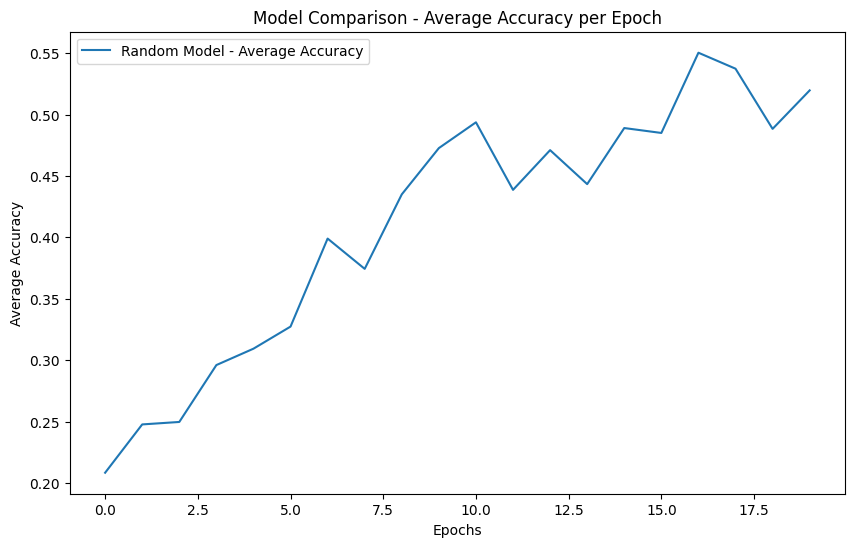

In [11]:
get_average_score(3)